# Informer application

## Download code and dataset

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 576 (delta 199), reused 188 (delta 188), pack-reused 354
Receiving objects: 100% (576/576), 6.48 MiB | 13.24 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 25), reused 20 (delta 20), pack-reused 159
Receiving objects: 100% (187/187), 3.86 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (62/62), done.
ETDataset  Informer2020  sample_data


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [3]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [4]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = '/content/drive/MyDrive/DeepLearning/' # root path of data file
args.data_path = 'filtered_data_without_index.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:
# [s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

# multiply by 6 because in each hour, there are 6 observations
# keep the ratio 4:2:1 the same (original 96:48:24)
args.seq_len = 96     # input sequence length of Informer encoder
args.label_len = 48   # start token length of Informer decoder
args.pred_len = 45*24    # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 10 # encoder input size
args.dec_in = 10 # decoder input size
args.c_out = 10 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training
#'/content/drive/MyDrive/Deep Learning Mini-Project/4_final_project/4_code/data/ETTh1_modified.csv'
args.num_workers = 0
args.itr = 1
args.train_epochs = 6 # original 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [7]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [8]:
# Set augments by using data name
data_parser = {
    #args.data:{'data':data.path, 'T':'OT', args.feature:[args.enc_in?, args.dec_in?, args.c_out?]}
    'ETTh1':{'data':'ETTh1_modified.csv','T':'OT','M':[10,10,10],'S':[1,1,1],'MS':[10,10,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [9]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [10]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'ETTh1', 'root_path': '/content/drive/MyDrive/DeepLearning/', 'data_path': 'ETTh1_modified.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 1080, 'enc_in': 10, 'dec_in': 10, 'c_out': 10, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [11]:
Exp = Exp_Informer

In [40]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftM_sl96_ll48_pl1080_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 7465
val 1801
test 1801
	iters: 100, epoch: 1 | loss: 0.8097255
	speed: 0.1934s/iter; left time: 251.2283s
	iters: 200, epoch: 1 | loss: 0.8239695
	speed: 0.1990s/iter; left time: 238.5647s
Epoch: 1 cost time: 45.94141101837158
Epoch: 1, Steps: 233 | Train Loss: 0.8920325 Vali Loss: 0.8442054 Test Loss: 0.7442928
Validation loss decreased (inf --> 0.844205).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.7168694
	speed: 0.3722s/iter; left time: 396.8017s
	iters: 200, epoch: 2 | loss: 0.7497817
	speed: 0.1979s/iter; left time: 191.2068s
Epoch: 2 cost time: 46.27942252159119
Epoch: 2, Steps: 233 | Train Loss: 0.7567955 Vali Loss: 0.8587841 Test Loss: 0.7581216
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.7136365
	speed: 0.3654s/ite

In [41]:
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

>>>>>>>testing : informer_ETTh1_ftM_sl96_ll48_pl1080_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
test 1801
test shape: (56, 32, 1080, 10) (56, 32, 1080, 10)
test shape: (1792, 1080, 10) (1792, 1080, 10)
mse:0.7439651489257812, mae:0.614238440990448


In [42]:
import numpy as np
import matplotlib.pyplot as plt
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((1792, 1080, 10), (1792, 1080, 10))

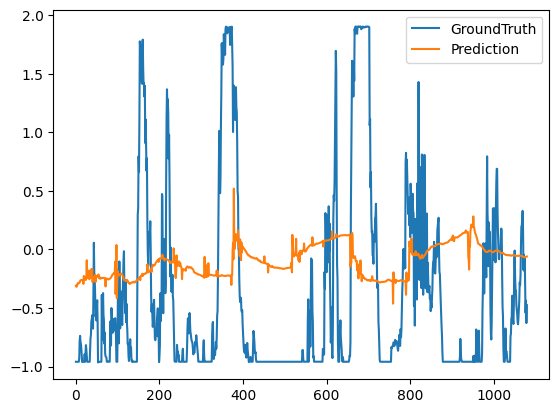

In [28]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

In [55]:
import pandas as pd
from google.colab import files

# Convert numpy arrays to DataFrame
# save only the last column (target feature)
pred_df = pd.DataFrame(preds[0,:,-1])
true_df = pd.DataFrame(trues[0,:,-1])

# Save as CSV files
pred_csv_path = '/content/results/informer_ETTh1_ftM_sl96_ll48_pl1080_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/pred.csv'
true_csv_path = '/content/results/informer_ETTh1_ftM_sl96_ll48_pl1080_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0/true.csv'
pred_df.to_csv(pred_csv_path, index=False)
true_df.to_csv(true_csv_path, index=False)

# Trigger the downloads
files.download(pred_csv_path)
files.download(true_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>